# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [4]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\venkatson\AppData\Local\Temp\pip-install-kmwwcwsn\tensorflow-gpu_2aa419cbbdc44ce3b32d623d1cf83322\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did

### 1.2 Collect Images Using OpenCV

In [5]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('DATA','IMAGES')
number_images = 13

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.7)

    if cv2.waitKey(1) & 0xFF == 27:
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [8]:
!labelme

   QT_AUTO_SCREEN_SCALE_FACTOR to enable platform plugin controlled per-screen factors.
   QT_SCREEN_SCALE_FACTORS to set per-screen DPI.
   QT_SCALE_FACTOR to set the application global scale factor.


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

### 2.3 Load Image into TF Data Pipeline

In [11]:
images = tf.data.Dataset.list_files('DATA\\train\\IMAGES\\*.jpg')

In [12]:
images.as_numpy_iterator().next()

b'DATA\\train\\IMAGES\\c07e281c-d7c7-11ed-b12f-046c596601f6.jpg'

In [20]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [14]:
images = images.map(load_image)

In [15]:
images.as_numpy_iterator().next()

array([[[134, 116, 140],
        [132, 114, 140],
        [133, 117, 146],
        ...,
        [146, 177, 171],
        [160, 185, 181],
        [164, 184, 182]],

       [[139, 121, 143],
        [134, 119, 142],
        [133, 117, 144],
        ...,
        [148, 179, 173],
        [161, 183, 180],
        [161, 181, 179]],

       [[146, 132, 149],
        [141, 126, 145],
        [133, 118, 141],
        ...,
        [148, 174, 171],
        [158, 180, 177],
        [164, 183, 181]],

       ...,

       [[111, 131, 130],
        [109, 129, 128],
        [103, 123, 124],
        ...,
        [ 70,  70,  58],
        [ 66,  66,  56],
        [ 60,  60,  52]],

       [[110, 128, 130],
        [112, 130, 132],
        [113, 131, 135],
        ...,
        [ 81,  79,  67],
        [ 72,  72,  62],
        [ 65,  65,  55]],

       [[105, 123, 125],
        [108, 126, 128],
        [114, 132, 136],
        ...,
        [ 68,  66,  54],
        [ 73,  73,  63],
        [ 74,  74,  64]]

In [16]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [17]:
image_generator = images.batch(4).as_numpy_iterator()

In [18]:
plot_images = image_generator.next()

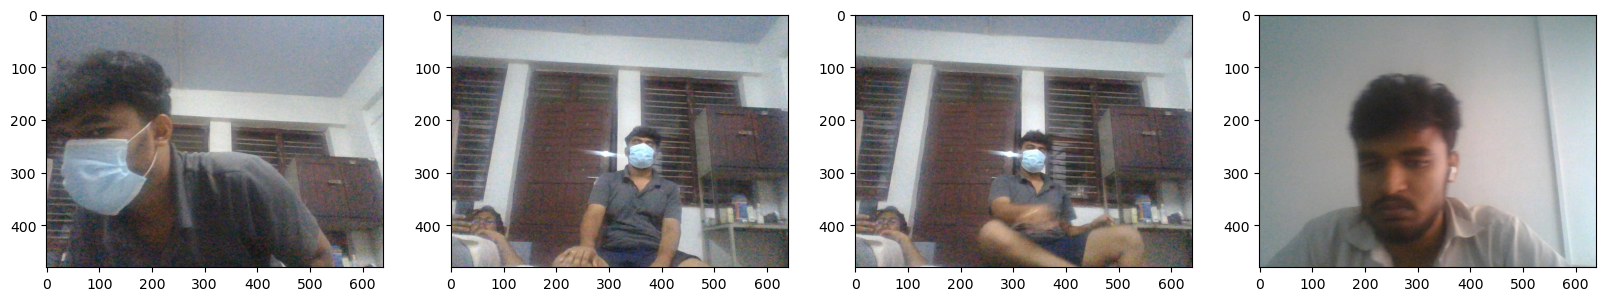

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [7]:
for partition in ['train','test','val']:
    for folder in ['mask','nomask']:
        path=os.path.join('DATA',partition,folder)
        if not os.path.exists(path):
            !mkdir {path}

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [14]:
import albumentations as alb

In [15]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [22]:
img = cv2.imread(os.path.join('DATA','train', 'IMAGES','541a75e8-d7c7-11ed-8b61-046c596601f6.jpg'))

In [25]:
with open(os.path.join('DATA', 'train', 'LABELS', '541a75e8-d7c7-11ed-8b61-046c596601f6.json'), 'r') as f:
    label = json.load(f)

In [26]:
label['shapes'][0]['points']

[[306.9230769230769, 129.74358974358972],
 [418.71794871794873, 248.7179487179487]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [27]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [28]:
coords

[306.9230769230769, 129.74358974358972, 418.71794871794873, 248.7179487179487]

In [29]:
coords = list(np.divide(coords, [640,480,640,480]))

In [30]:
coords

[0.47956730769230765,
 0.2702991452991453,
 0.6542467948717949,
 0.5181623931623931]

### 4.4 Apply Augmentations and View Results

In [31]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [32]:
augmented['bboxes'][0][2:]

(0.8527065527065527, 0.7139031339031339)

In [33]:
augmented['bboxes']

[(0.6042735042735042,
  0.44951566951566957,
  0.8527065527065527,
  0.7139031339031339)]

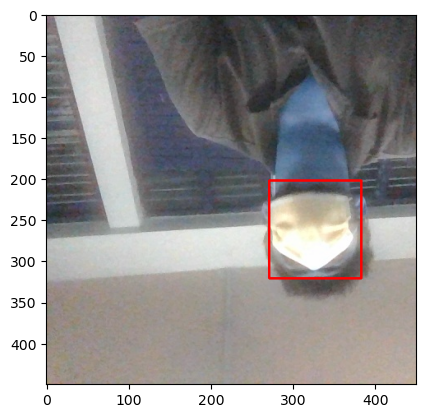

In [34]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [11]:
# p='DATA/test/LABELS/5246f22d-d7c7-11ed-9fb2-046c596601f6.json'
# with open(p, 'r') as f:
#     label = json.load(f)
# label['shapes'][0]['label']

'Mask'

In [17]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('DATA', partition, 'IMAGES')):
        img = cv2.imread(os.path.join('DATA', partition, 'IMAGES', image))

    
        label_path = os.path.join('DATA', partition, 'LABELS', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))
        class_label=label['shapes'][0]['label']

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=[class_label])
                cv2.imwrite(os.path.join('AUG_DATA', partition, 'IMAGES', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    elif(class_label=='Mask'): 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                    elif(class_label=='No Mask'): 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 0
                        
                


                with open(os.path.join('AUG_DATA', partition, 'LABELS', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [21]:
train_images = tf.data.Dataset.list_files('AUG_DATA\\train\\IMAGES\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [22]:
test_images = tf.data.Dataset.list_files('AUG_DATA\\test\\IMAGES\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [23]:
val_images = tf.data.Dataset.list_files('AUG_DATA\\val\\IMAGES\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [24]:
train_images.as_numpy_iterator().next()

array([[[0.25680146, 0.21966912, 0.19607843],
        [0.23351716, 0.21390931, 0.19871323],
        [0.20373775, 0.19448529, 0.18057598],
        ...,
        [0.38131127, 0.39699754, 0.40582108],
        [0.43474266, 0.4401348 , 0.45710784],
        [0.46936274, 0.46838236, 0.48743874]],

       [[0.27340686, 0.23988971, 0.23743872],
        [0.259375  , 0.23682599, 0.23633578],
        [0.21519607, 0.20079657, 0.18958333],
        ...,
        [0.5598652 , 0.579473  , 0.56378675],
        [0.7626838 , 0.7719976 , 0.7597426 ],
        [0.7626838 , 0.77144605, 0.759375  ]],

       [[0.25079656, 0.25196078, 0.25735295],
        [0.20686275, 0.2127451 , 0.20980392],
        [0.18412991, 0.19185048, 0.18014705],
        ...,
        [0.7663603 , 0.78204656, 0.778125  ],
        [0.7982843 , 0.81397057, 0.82389706],
        [0.8079657 , 0.82365197, 0.8344363 ]],

       ...,

       [[0.62941176, 0.7       , 0.78333336],
        [0.63327205, 0.7038603 , 0.78229165],
        [0.6454657 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [25]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [27]:
train_labels = tf.data.Dataset.list_files('AUG_DATA\\train\\LABELS\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [29]:
test_labels = tf.data.Dataset.list_files('AUG_DATA\\test\\LABELS\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [30]:
val_labels = tf.data.Dataset.list_files('AUG_DATA\\val\\LABELS\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [31]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2004, 0.396 , 0.4487, 0.729 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [32]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2880, 2880, 1200, 1200, 1380, 1380)

### 7.2 Create Final Datasets (Images/Labels)

In [33]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [34]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [35]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [37]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0]], dtype=uint8),
 array([[0.4612, 0.36  , 0.574 , 0.5107],
        [0.2961, 0.3577, 0.533 , 0.6133],
        [0.283 , 0.3718, 0.5825, 0.7505],
        [0.2866, 0.1575, 0.558 , 0.6133],
        [0.8115, 0.0974, 1.    , 0.624 ],
        [0.626 , 0.44  , 0.8906, 0.7817],
        [0.2488, 0.3252, 0.5107, 0.701 ],
        [0.2947, 0.2573, 0.5933, 0.628 ]], dtype=float16))

### 7.3 View Images and Annotations

In [38]:
data_samples = train.as_numpy_iterator()

In [39]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


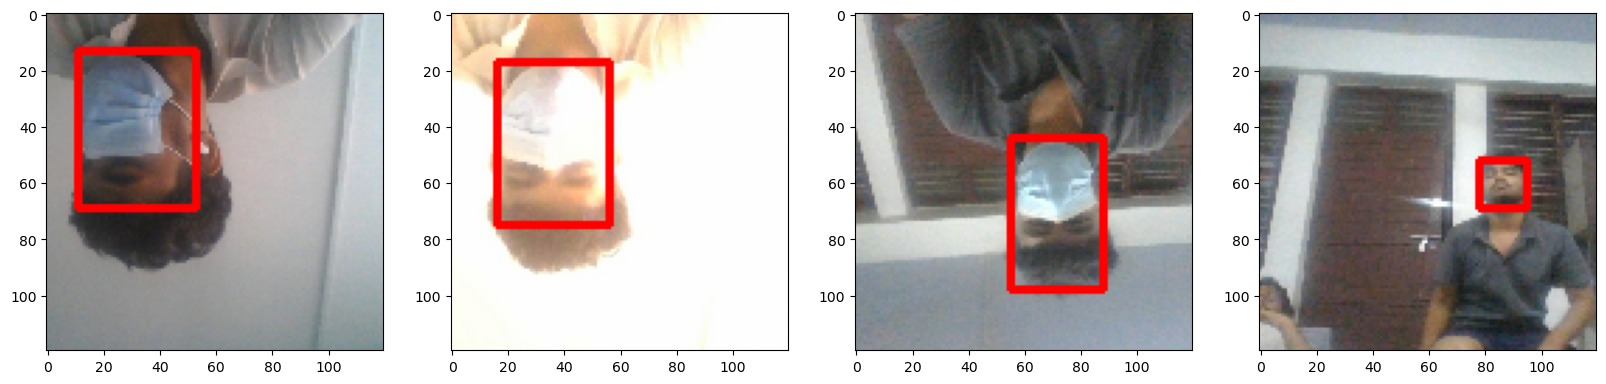

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [54]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 57s 1us/step


In [55]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [56]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [57]:
facetracker = build_model()

In [58]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [59]:
X, y = train.as_numpy_iterator().next()

In [60]:
X.shape

(8, 120, 120, 3)

In [61]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 673ms/step


In [62]:
classes, coords

(array([[0.451821  ],
        [0.4757608 ],
        [0.44653118],
        [0.4783198 ],
        [0.46312493],
        [0.43869975],
        [0.4616658 ],
        [0.4898969 ]], dtype=float32),
 array([[0.4408325 , 0.49202606, 0.41180936, 0.36338577],
        [0.35306317, 0.42933303, 0.391551  , 0.35806325],
        [0.4554549 , 0.4421698 , 0.48660138, 0.32183087],
        [0.3993831 , 0.41432422, 0.41298172, 0.35312748],
        [0.41780478, 0.37102336, 0.46627906, 0.32836518],
        [0.41112512, 0.45339575, 0.3982839 , 0.35809648],
        [0.47290036, 0.39265606, 0.48414645, 0.30785638],
        [0.41089743, 0.37399918, 0.4131047 , 0.3785854 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [63]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [67]:
opt= tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [68]:
# opt = tf.keras.optimizers.Adam()

### 9.2 Create Localization Loss and Classification Loss

In [69]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [70]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [71]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2716622>

In [72]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7701503>

In [73]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2716622>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [74]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [75]:
model = FaceTracker(facetracker)

In [76]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [77]:
logdir='logs'

In [78]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [80]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
360/360 [==============================] - 696s 2s/step - total_loss: 0.0048 - class_loss: 0.0021 - regress_loss: 0.0038 - val_total_loss: 0.0404 - val_class_loss: 0.0028 - val_regress_loss: 0.0390
Epoch 2/10
360/360 [==============================] - 701s 2s/step - total_loss: 0.0096 - class_loss: 0.0040 - regress_loss: 0.0076 - val_total_loss: 0.3032 - val_class_loss: 0.3225 - val_regress_loss: 0.1419
Epoch 3/10
360/360 [==============================] - 593s 2s/step - total_loss: 0.0036 - class_loss: 0.0013 - regress_loss: 0.0030 - val_total_loss: 0.0163 - val_class_loss: 1.1722e-04 - val_regress_loss: 0.0163
Epoch 4/10
360/360 [==============================] - 588s 2s/step - total_loss: 0.0036 - class_loss: 0.0012 - regress_loss: 0.0030 - val_total_loss: 0.0175 - val_class_loss: 2.2993e-05 - val_regress_loss: 0.0175
Epoch 5/10
360/360 [==============================] - 589s 2s/step - total_loss: 0.0028 - class_loss: 0.0011 - regress_loss: 0.0022 - val_total_loss: 0.1287

### 10.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [1]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('FaceMaskDetector.h5')

In [2]:
facetracker = load_model('FaceMaskDetectorFinal.h5')

### 11.3 Real Time Detection

In [3]:
import cv2
import tensorflow as tf
import numpy as np

In [4]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] >= 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (0,255,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (0,255,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame,'Mask',tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
    elif yhat[0] < 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (0,0,255), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [140,0])), 
                            (0,0,255), -1)
        
        # Controls the text rendered
        cv2.putText(frame,'No Mask',tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == 27:
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 94ms/step
